### Name__ ABDULMALIK ALHASSAN SHAABA, School ID ALT_SOD_024_YYYY
Link to the Document: https://drive.google.com/file/d/1_OX-S5isCxu0kr2Sp4IamS1uIEZ638gX/view?usp=sharing


### Introduction
In the fast-paced digital media landscape, understanding how and when content performs best is critical to audience engagement. Media platforms frequently experiment with publishing strategies to optimize reach, clicks, and reader interaction. One common approach is A/B testing, where two versions of content are compared to determine which performs better.
This project, titled “Which Headline Works Better? A/B Testing with Real API Data,” simulates an A/B test using real-world news article data retrieved from the Guardian Open Platform API. The primary goal is to investigate whether the time of publication, specifically morning (6 AM – 12 PM) and evening (6 PM – 12 AM) affects the length of articles, which can be a proxy for editorial depth or writer effort.
To achieve this, I:
1. Collected and cleaned the article metadata using Python, request library and the pandas
2. Simulated experimental groups based on time of day (Group A for morning and Group B for Evenning)
3. Explored statistical differences using aggregation and a two-sample t-test
4. Visualized the results to uncover patterns in publishing behavior.
While word count is not a direct measure of article success, this analysis provides a foundation for designing more complex A/B tests using engagement metrics in future work.

In [3]:
# Loading the libraries to be use during the analysis
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

## Step 1: API Integration and Data Retrieval

In [6]:
# API Configuration
API_KEY = "YYYYYYYYYYYYYYYYYYYYYYY"  # Obtained by creating a new account with The Guardian to access their content API
URL = 'https://content.guardianapis.com/search'  # Base URL for querying The Guardian's search API

# Defining Request Parameters
params = {
    'api-key': API_KEY,
    'from-date': '2024-06-01',  # Start date for article publication (helps narrow the time range)
    'to-date': '2024-06-10',    # End date for article publication
    'show-fields': 'headline,bodyText,wordcount',  # Specifies which extra article fields to return
    'page-size': 200,   # Maximum number of articles per page which can be adjusted
    'page': 1           # Page number of results (can be looped for pagination)
}

# Making API Request
response = requests.get(URL, params=params)  # Sends GET request with defined parameters
data = response.json()  # Parses the JSON response from the API into a Python dictionary

# Normalize Nested JSON Structure into a DataFrame 
articles = pd.json_normalize(data['response']['results'])  # This flattens nested article data for easier analysis

# Selecting Only Relevant Columns
df = articles[[
    'webTitle',
    'webPublicationDate',
    'sectionName',
    'fields.wordcount'
]].copy()  # Keeps only necessary fields for the analysis (title, date, section, and word count)

# Renaming Columns for Clarity and Consistency
df.rename(columns={
    'webTitle': 'title',               # Renamed for simplicity
    'webPublicationDate': 'published_at',  # More intuitive and Pythonic
    'sectionName': 'section',          # Keeps naming consistent
    'fields.wordcount': 'word_count'   # Matches naming convention and easier to reference in code
}, inplace=True)

# Converting Data Types for Analysis
df['published_at'] = pd.to_datetime(df['published_at'])  # Ensures dates are in datetime format for filtering or plotting
df['word_count'] = pd.to_numeric(df['word_count'], errors='coerce')  # Converts word count to numeric, handles non-numeric Properly
print(df.head())  # Having a peek look into the first few rows to verify structure and values


                                               title  \
0  Shaken and stirred: Trump’s golf course liquor...   
1  Media studies are popular, dynamic and have ‘p...   
2  Water births do not increase risk of complicat...   
3  One in three Asda staff have been attacked at ...   
4                          Quick crossword No 16,879   

               published_at         section  word_count  
0 2024-06-10 23:41:28+00:00         US news         360  
1 2024-06-10 23:01:27+00:00       Education         502  
2 2024-06-10 23:01:27+00:00  Life and style         386  
3 2024-06-10 23:01:27+00:00        Business         526  
4 2024-06-10 23:00:27+00:00      Crosswords           0  


In [8]:
len(df) # checking the Number of Articles i got

200

##  Step 2: Simulating A/B Test Groups

In [11]:
# Extracting the hour from the timestamp
df['hour'] = df['published_at'].dt.hour

# Assigning groups based on hour, for morning being 6AM – 12PM and evening being 6PM – 12AM
def assign_group(hour):
    if 6 <= hour < 12:
        return 'A'  # Morning
    elif 18 <= hour < 24:
        return 'B'  # Evening
    else:
        return None  # Exclude other times incase of any error that might have occured

df['group'] = df['hour'].apply(assign_group)

# Filter out rows not in A or B
df_ab = df[df['group'].isin(['A', 'B'])].copy()

# Peek look into the group count
print(df_ab['group'].value_counts())
print(df_ab[['title', 'hour', 'group']].head())


group
A    59
B    33
Name: count, dtype: int64
                                               title  hour group
0  Shaken and stirred: Trump’s golf course liquor...    23     B
1  Media studies are popular, dynamic and have ‘p...    23     B
2  Water births do not increase risk of complicat...    23     B
3  One in three Asda staff have been attacked at ...    23     B
4                          Quick crossword No 16,879    23     B


### Step 3: Data Cleaning & Handling Missing Values

In [14]:
# Checking for missing values
print(df_ab.isnull().sum())

# Drop rows with missing word_count (you could also fillna with median if needed)
df_ab = df_ab.dropna(subset=['word_count'])

# Convert word count to int to ease analysis
df_ab['word_count'] = df_ab['word_count'].astype(int)

# Droping duplicates by title if any
df_ab = df_ab.drop_duplicates(subset='title')


title           0
published_at    0
section         0
word_count      0
hour            0
group           0
dtype: int64


In [16]:
# Checking for outliers using IQR
Q1 = df_ab['word_count'].quantile(0.25)
Q3 = df_ab['word_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering out outliers
df_ab_clean = df_ab[(df_ab['word_count'] >= lower_bound) & (df_ab['word_count'] <= upper_bound)]

print(f"Original: {len(df_ab)} articles in number")
print(f"Cleaned: {len(df_ab_clean)} articles in number")


Original: 92 articles in number
Cleaned: 85 articles in number


### Step 4: Indexing and Subsetting

In [19]:
# Using .loc to get all Group A articles in the 'Technology' section
group_a_tech = df_ab_clean.loc[(df_ab_clean['group'] == 'A') & (df_ab_clean['section'] == 'Technology')]
print(group_a_tech[['title', 'section', 'word_count']].head())

# Using .iloc to get the first 5 rows
print(df_ab_clean.iloc[:5])

# Subseting to key columns only
subset_df = df_ab_clean.loc[:, ['title', 'group', 'section', 'word_count']]
print(subset_df.head())

# Filter for word count greater than 800
long_articles = df_ab_clean[df_ab_clean['word_count'] > 800]
print(f"{len(long_articles)} articles have word count greater than 800")


Empty DataFrame
Columns: [title, section, word_count]
Index: []
                                               title  \
0  Shaken and stirred: Trump’s golf course liquor...   
1  Media studies are popular, dynamic and have ‘p...   
2  Water births do not increase risk of complicat...   
3  One in three Asda staff have been attacked at ...   
4                          Quick crossword No 16,879   

               published_at         section  word_count  hour group  
0 2024-06-10 23:41:28+00:00         US news         360    23     B  
1 2024-06-10 23:01:27+00:00       Education         502    23     B  
2 2024-06-10 23:01:27+00:00  Life and style         386    23     B  
3 2024-06-10 23:01:27+00:00        Business         526    23     B  
4 2024-06-10 23:00:27+00:00      Crosswords           0    23     B  
                                               title group         section  \
0  Shaken and stirred: Trump’s golf course liquor...     B         US news   
1  Media studies are po

### Step 5: Grouped Analysis & Aggregation

In [22]:
# Doing some basic statistic by group to under the distribution
group_stats = df_ab_clean.groupby('group')['word_count'].agg(['count', 'mean', 'median', 'min', 'max']).reset_index()
print(group_stats)


  group  count        mean  median  min   max
0     A     54  702.888889   735.0    0  1724
1     B     31  635.806452   567.0    0  1238


In [24]:
# Checking for the most common section in each group
most_common_sections = df_ab_clean.groupby(['group', 'section']).size().reset_index(name='count')
most_common_sections = most_common_sections.sort_values(['group', 'count'], ascending=[True, False])

print(most_common_sections.head(100))


   group             section  count
15     A             Opinion      5
16     A            Politics      5
2      A               Books      4
14     A               Music      4
1      A      Australia news      3
6      A         Environment      3
7      A                Film      3
19     A               Sport      3
24     A          World news      3
3      A            Business      2
9      A            Football      2
10     A               Games      2
12     A      Life and style      2
13     A               Money      2
0      A      Art and design      1
4      A          Crosswords      1
5      A             Culture      1
8      A                Food      1
11     A  Global development      1
17     A             Science      1
18     A             Society      1
20     A               Stage      1
21     A              Travel      1
22     A             UK news      1
23     A             US news      1
36     B               Sport      5
35     B            Politics

### Step 6: A/B Test Execution

In [27]:
# Filtering out wordless articles
df_test = df_ab_clean[df_ab_clean['word_count'] > 0]

# Separate groups
group_a = df_test[df_test['group'] == 'A']['word_count']
group_b = df_test[df_test['group'] == 'B']['word_count']

# Run two-sample t-test
t_stat, p_val = ttest_ind(group_a, group_b, equal_var=False)  # Welch's t-test

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")


T-statistic: 0.508
P-value: 0.6132


### Step 7: Visualization & Final Insights

C:\Users\Admin\AppData\Local\Temp\ipykernel_13896\475904696.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x='group', y='word_count', palette='pastel')


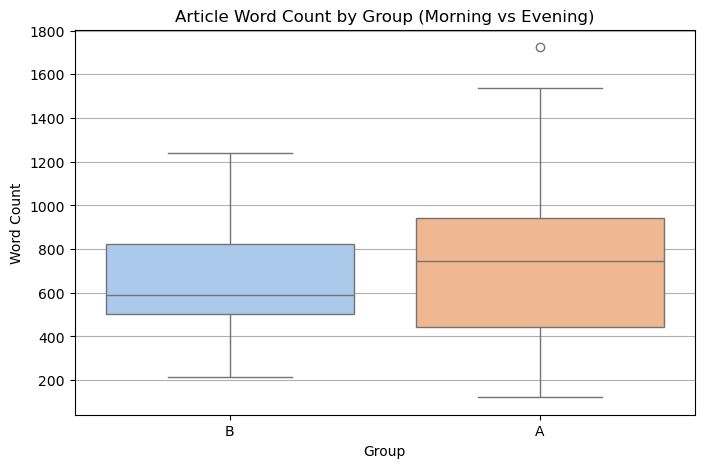

In [30]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_test, x='group', y='word_count', palette='pastel')
plt.title('Article Word Count by Group (Morning vs Evening)')
plt.xlabel('Group')
plt.ylabel('Word Count')
plt.grid(True, axis='y')
plt.show()


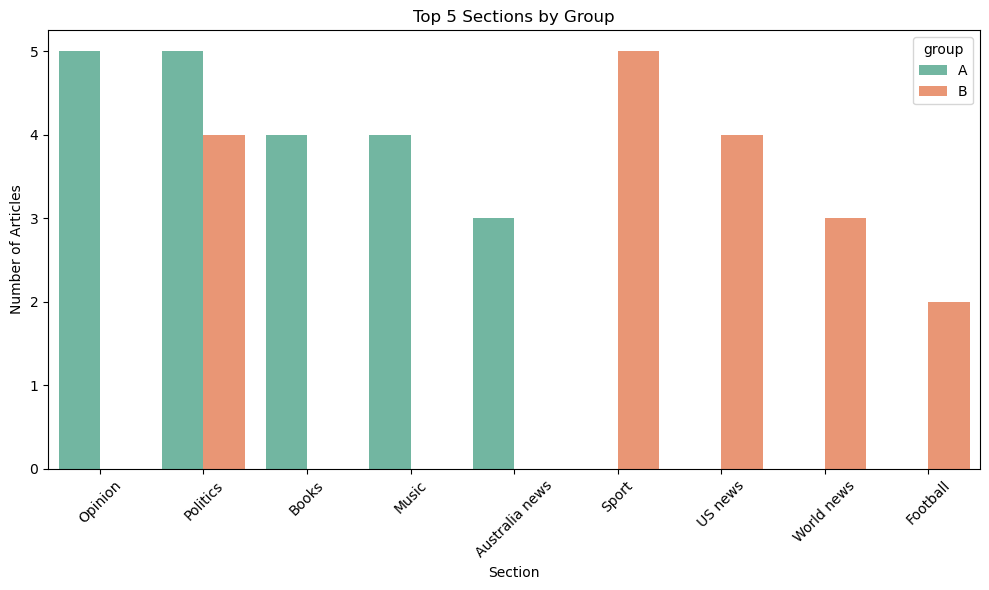

In [32]:
top_sections = (
    df_test.groupby(['group', 'section'])
    .size()
    .reset_index(name='count')
    .sort_values(['group', 'count'], ascending=[True, False])
    .groupby('group')
    .head(5)
)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_sections, x='section', y='count', hue='group', palette='Set2')
plt.title('Top 5 Sections by Group')
plt.xlabel('Section')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Final Summary & Recommendation

Summary of Findings
Data Overview:
Total articles pulled: 200
Articles after filtering by time: 92
After cleaning (missing values, outliers removed): 85 articles
Group A (Morning): 54 articles
Group B (Evening): 31 articles



STATISTICS

Metric	             Group A (Morning)	            Group B (Evening)
Mean Word Count	     703 words	                    636 words
Median Word Count	 735 words	                    567 words
Max Word Count	     1,724	                        1,238

It was observed that group A articles are generally longer than Group B, on average and group A also featured more editorial style content (e.g., Opinion, Politics), while Group B leaned toward Sport and World news.

A/B Test (T-test)
Null Hypothesis: No difference in article length between morning and evening posts.
P-value: 0.6132
Interpretation: Not statistically significant (p > 0.05). The observed differences could be due to chance.

Visual Insights:
Box Plot: Morning articles (Group A) show slightly higher median word counts, but there is significant overlap and variability in both groups.
Bar Chart: Top sections differ by group:
Group A: Editorial content (Opinion, Politics, Books)
Group B: News and Sports coverage (Sport, US News, World News)

Recommendation
Although Group A articles were slightly longer, our statistical test shows no significant difference in article word count between morning and evening publications. Therefore, the platform should not rely on time-of-day alone to influence article strategy, insteadvconsider testing other variables like headline sentiment, readability score, or topic type for more impactful A/B experiments.
Also, if the future data can includes engagement metrics such as shares and clicks, that could offer a more reliable outcome variable than just word count.